# A New QR Algorithm

The step we use is given by $$A(nb+1:n,nb+1:n)\leftarrow A(nb+1:n, nb+1:n)-A(nb+1:n,1:nb)\times A(1:nb,nb+1:n)$$

In [28]:
using LinearAlgebra
using Plots


In [29]:
function NewHouseholderQR(A)
    n,_ = size(A)
    Tau = zeros(ComplexF64, n-1)
    for nb in 1:(n-1)
        phase = A[nb,nb]/abs(A[nb,nb])
        Tau[nb] = (1+abs(A[nb, nb]))
        A[nb, nb] += phase
        A[nb:n, nb] = A[nb:n, nb]/(phase*Tau[nb])
        A[nb,nb] = -phase
        A[nb+1:n,nb+1:n]= A[nb+1:n, nb+1:n]-A[nb+1:n,nb].*A[nb:nb, nb+1:n]
    end
    A, Tau
end

function GetR(A, Tau)
    diagm(0 => diag(A, 0))
end

function GetQ(A, Tau)
    n, _ = size(A)
    Q = diagm(ones(ComplexF64, n))
    for i in n-1:-1:1
        u = A[i:n, i]
        u[1] = 1
        Q[i:n, :] = Q[i:n, :] - Tau[i] * u * (u' * Q[i:n, :])
    end
    Q
end

GetQ (generic function with 1 method)

In [30]:

function GenerateRandUnitaries(n)
    [Matrix(qr(rand(ComplexF64, (2^i,2^i))).Q) for i=1:n]
end

n = 10
U = Matrix(qr(rand(ComplexF64, (2^n, 2^n))).Q)
UCopy = deepcopy(U)
OurHH = NewHouseholderQR(U)
OurR = GetR(OurHH[1], OurHH[2])
OurQ = GetQ(OurHH[1], OurHH[2])
Res = (OurQ * OurR)
UCopy≈Res

true

Verification function. I am trying to add other stuff too.

In [31]:
function verify_qr(A_OG, A_Factor, Tau) # function for easy verification
    B= deepcopy(A_Factor)

    Q = GetQ(B, Tau)
    R = GetR(B, Tau)

    Result=(Q*R)
    success = A_OG ≈Result

    if success ==true
        println("passed")
    else
        println("failed")
    end
    
    return success
end

function GenRandUnitary(n)
    return Matrix(qr(rand(ComplexF64, 2^n, 2^n)).Q)
end

GenRandUnitary (generic function with 1 method)

In [32]:
n = 10

U1 = GenRandUnitary(n)
U1_copy = deepcopy(U1)
A1, Tau1 = NewHouseholderQR(U1_copy)
verify_qr(U1, A1, Tau1)


passed


true

n = 1
passed
n = 2
passed
n = 3
passed
n = 4
passed
n = 5
passed
n = 6
passed
n = 7
passed
n = 8
passed
n = 9
passed
n = 10
QR: 2.402863 seconds
passed
Verification: 6.49428 seconds
n = 11
Generation: 1.229373 seconds
QR: 30.573265 seconds
passed
Verification: 71.268213 seconds


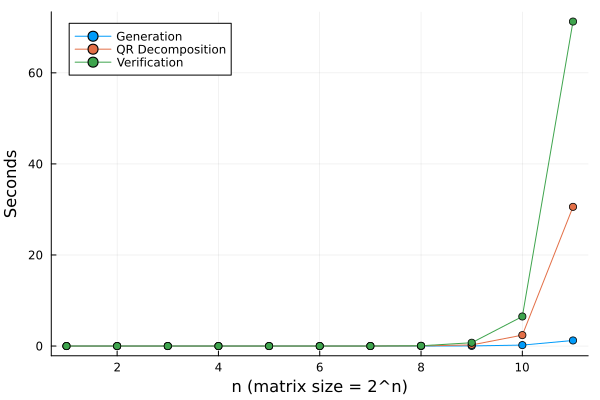

In [39]:
n_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
gen_times = Float64[]
qr_times = Float64[]
verify_times = Float64[]

for n in n_values
    println("n = $n")
    gen_time = @elapsed U = GenRandUnitary(n)

    if gen_time > 1.0
        println("Generation: $(round(gen_time, digits=6)) seconds")
    end
    
    U_copy = deepcopy(U)
    
    qr_time = @elapsed A, Tau = NewHouseholderQR(U_copy)
    if qr_time > 1.0
        println("QR: $(round(qr_time, digits=6)) seconds")
    end
    
    verify_time = @elapsed verify_qr(U, A, Tau)
    if verify_time > 1.0
        println("Verification: $(round(verify_time, digits=6)) seconds")
    end
    
    push!(gen_times, gen_time)
    push!(qr_times, qr_time)
    push!(verify_times, verify_time)
end

plot(n_values, [gen_times qr_times verify_times],
     label=["Generation" "QR Decomposition" "Verification"],
     xlabel="n (matrix size = 2^n)",
     ylabel="Seconds",
     marker=:circle,
     legend=:topleft)